# Requirements

- install node2vec code and add executable to `node2vec` directory in top level of the project (code: https://snap.stanford.edu/node2vec)
- compile GED code (graph embedding divergence), 
  the base implementation of the framework in C (the code is included, and can also be found at      https://github.com/ftheberge/Comparing_Graph_Embeddings) 
- new package to install: 'pip install --no-dependencies graphrole'
- adjust location of data and code in next cell
  

In [1]:
## the data directory
datadir="../Datasets/"

## location of the GED code
GED="../GED/GED"

"../GED/GED"

In [2]:
## node and edge colors
cls = ["red","green","blue"]

3-element Vector{String}:
 "red"
 "green"
 "blue"

In [3]:
using PyCall

In [4]:
using PyPlot

In [5]:
using LightGraphs

In [6]:
using GraphPlot

In [7]:
using Statistics

In [8]:
using Random

In [9]:
using LinearAlgebra

In [10]:
using DataFrames

In [11]:
using CSV

In [12]:
using DecisionTree

In [13]:
using FreqTables

In [14]:
using StatsBase

In [15]:
using Clustering

In [16]:
ig = pyimport("igraph")

PyObject <module 'igraph' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/igraph/__init__.py'>

In [17]:
umap = pyimport("umap")

PyObject <module 'umap' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/umap/__init__.py'>

In [18]:
partition_igraph = pyimport("partition_igraph")

PyObject <module 'partition_igraph' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/partition_igraph/__init__.py'>

In [19]:
CHS = pyimport("sklearn.metrics").calinski_harabasz_score

PyObject <function calinski_harabasz_score at 0x7fba10941560>

In [20]:
AMI = pyimport("sklearn.metrics").adjusted_mutual_info_score

PyObject <function adjusted_mutual_info_score at 0x7fba10920950>

In [21]:
np = pyimport("numpy")

PyObject <module 'numpy' from '/home/bkamins/.julia/conda/3/lib/python3.7/site-packages/numpy/__init__.py'>

In [22]:
DBSCAN = pyimport("sklearn.cluster").dbscan

PyObject <function dbscan at 0x7fba06924d40>

In [73]:
LogisticRegression = pyimport("sklearn.linear_model").LogisticRegression

PyObject <class 'sklearn.linear_model._logistic.LogisticRegression'>

# A few useful functions

In [23]:
function ig2lg(ig_g)
    lg_g = SimpleGraph(ig_g.vcount())
    for e in ig_g.es()
        add_edge!(lg_g, e.source + 1, e.target + 1)
    end
    return lg_g
end

ig2lg (generic function with 1 method)

In [85]:
function binary_operator(u, v, op=:had)
    op == :had && return u .* v
    op == :l1 && return abs.(u .- v)
    op == :l2 && return (u .- v) .^ 2
    op == :avg && return (u .+ v) ./ 2.0
    throw(ArgumentError("unknown op"))
end

binary_operator (generic function with 2 methods)

In [25]:
function Hope(g, sim, dim; beta=0.01, alpha=0.5)
    dim = dim*2
    A = g.get_adjacency().data
    n = g.vcount()
    ## Katz
    if sim == :katz
        M_g = I - beta * A
        M_l = beta * A
    end
    ## Adamic-Adar
    if sim == :aa
        M_g = I
        D = diagm((x -> x > 1 ? 1/log(x) : 0.0).(g.degree()))
        M_l = A*D*A
        M_l[diagind(M_l)] .= 0.0
    end
    ## Common neighbors
    if sim == :cn
        M_g = I
        M_l = A*A
    end
    ## personalized page rank
    if sim == :ppr
        P = mapslices(A, dims=1) do x
            s = sum(x)
            iszero(s) ? fill(1/n, n) : x / s
        end
        M_g = I-alpha*P
        M_l = (1-alpha)*I
    end
    S = M_g \ M_l
    k = div(dim, 2)
    u, s, vt = svd(S)
    X1 = u[:, 1:k] * diagm(sqrt.(s[1:k]))
    ## undirected graphs have identical source and target embeddings
    if !g.is_directed()
        return X1
    else
        X2 = vtu[:, 1:k] * diagm(sqrt.(s[1:k]))
        return [X1 X2]
    end
end

Hope (generic function with 1 method)

In [26]:
## save to disk to compute divergence
function saveEmbedding(X, g, fn="_embed")
    names = g.vs.get_attribute_values("name")
    open(fn, "w") do f
        println(f, size(X,1), " ", size(X, 2))
        for i in axes(X, 1)
            print(f, names[i], " ")
            for j in axes(X, 2)
                print(f, X[i, j])
                 j < size(X, 2) && print(f, " ")
            end
            println(f)
        end
    end
end

saveEmbedding (generic function with 2 methods)

In [27]:
## Computing JS divergence with GED code given edgelist, communities and embedding
function JS(edge_file, comm_file, embed_file, entropy=false)
    if entropy
        x = `$GED -E -g $edge_file -c $comm_file -e $embed_file`
    else
        x = `$GED -g $edge_file -c $comm_file -e $embed_file`
    end
    io = IOBuffer()
    run(pipeline(x, stdout=io), wait=true)
    s = split(String(take!(io)), " ")
    return parse(Float64, s[2])
end

JS (generic function with 2 methods)

In [28]:
## Laplacian eigenmaps embedding
function LE(g, dim=2)
    L_sym = g.laplacian(normalized=true)
    w, v = eigen(L_sym)
    return real.(v[:, 2:dim+1])
end


LE (generic function with 2 methods)

In [29]:
## Read embedding from file in node2vec format
## Map to layout format
## for visualization, we use UMAP if dim > 2
function embed2layout(fn="_embed")
    D = CSV.read(fn, DataFrame, header=false, datarow=2)
    if eltype(D[!, end]) === Missing
        D = D[!, 1:end-1]
    end
    Y = Matrix(select(D, Not(1)))
    if size(Y,2) >  2
        Y = umap.UMAP().fit_transform(Y)
    end
    return Y
end

embed2layout (generic function with 2 methods)

In [30]:
function readEmbedding(fn="_embed"; N2K=nothing)
    D = CSV.read(fn, DataFrame, header=false, datarow=2)
    if eltype(D[!, end]) === Missing
        D = D[!, 1:end-1]
    end
    Y = Matrix(select(D, Not(1)))

    if N2K !== nothing
        x = [N2K[i] for i in D[:, 1]]
        Y = Y[sortperm(x), :]
    end
    return Y
end

readEmbedding (generic function with 2 methods)

# Load and prepare datasets

* g: small ABCD graph (100 nodes), mainly for visualization and quick exampes
* G: larger ABCD graph (1000 nodes), for experiments
* z: zachary graph, for visualzation

## 1. Small ABCD graph 

100 vertices, 350 edges; avg degreee: 7.0, communities: 3


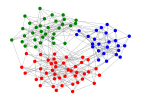

In [31]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_100.dat", directed=false)
c = np.loadtxt(datadir * "ABCD/abcd_100_comms.dat", dtype="uint16", usecols=(1))
g.vs.set_attribute_values("comm", [c[parse(Int, x.attributes()["name"])] for x in g.vs])

## print a few stats
println(g.vcount()," vertices, ",
        g.ecount()," edges; ",
        "avg degreee: ", mean(g.degree()),
        ", communities: ",maximum(g.vs.get_attribute_values("comm")))

## ground truth
gt = Dict(enumerate(g.vs.get_attribute_values("comm")))
## map between name to key
n2k = Dict((v, k) for (k, v) in enumerate(g.vs.get_attribute_values("name")))

v_color = cls[g.vs.get_attribute_values("comm")]
g_lg = ig2lg(g)
Random.seed!(2)
gplot(g_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

## 2. Larger ABCD graph

1000 vertices, 8327 edges; avg degreee: 16.654, communities: 12


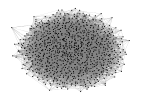

In [32]:
## read graph and communities
G = ig.Graph.Read_Ncol(datadir * "ABCD/abcd_1000.dat", directed=false)
C = np.loadtxt(datadir * "ABCD/abcd_1000_comms.dat", dtype="uint16", usecols=(1))
G.vs.set_attribute_values("comm", [C[parse(Int, x.attributes()["name"])] for x in G.vs])

## print a few stats
println(G.vcount()," vertices, ",
        G.ecount()," edges; ",
        "avg degreee: ", mean(G.degree()),
        ", communities: ",maximum(G.vs.get_attribute_values("comm")))

## ground truth
GT = Dict(enumerate(G.vs.get_attribute_values("comm")))
## map between name to key
N2K = Dict((v, k) for (k, v) in enumerate(G.vs.get_attribute_values("name")))

G_LG = ig2lg(G)
Random.seed!(2)
gplot(G_LG,
      NODESIZE=0.01, nodefillc="black",
      EDGELINEWIDTH=0.1, edgestrokec="gray") ## communities are far from obvious in 2d layout!

## 3. Zachary (karate) graph

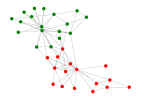

In [33]:
z = ig.Graph.Famous("zachary")
c = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1] .+ 1
z.vs.set_attribute_values("name", string.(0:z.vcount()-1))
z.vs.set_attribute_values("comm", [c[parse(Int, x.attributes()["name"])+1] for x in z.vs])

v_color = cls[z.vs.get_attribute_values("comm")]
z_lg = ig2lg(z)
Random.seed!(2)
gplot(z_lg,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Show various 2d layouts using small Zachary graph

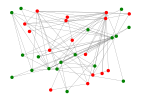

In [34]:
gplot(z_lg, layout=random_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

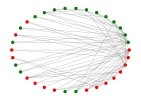

In [35]:
gplot(z_lg, layout=circular_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

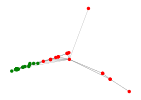

In [36]:
gplot(z_lg, layout=spectral_layout,
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Perform several embeddings -- Zachary graph
* node2vec from source code
* HOPE with different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

We use the framework to compute the "graph embedding divergence" (GED.c)

In [37]:
L=DataFrame()
DIM=[5,10,15]

3-element Vector{Int64}:
  5
 10
 15

In [38]:
## Hope
for dim in DIM, sim in (:katz,:ppr, :cn, :aa)
    X = Hope(z,sim,dim)
    saveEmbedding(X,z)
    jsd = JS(datadir * "Zachary/zachary.edgelist", datadir * "Zachary/zachary.ecg", "_embed")
    push!(L, (dim=dim, alg="hope", param=sim, jsd=jsd))
end

In [39]:
## LE
for dim in DIM
    X = LE(z,dim)
    saveEmbedding(X,z)
    jsd = JS(datadir * "Zachary/zachary.edgelist", datadir * "Zachary/zachary.ecg", "_embed")
    push!(L, (dim=dim, alg="le", param=nothing,jsd=jsd), cols=:union)
end

In [40]:
## node2vec is in my path
for dim in DIM, (p,q) in [(1,0.1),(0.1,1),(1,1)]
        x = `../node2vec/node2vec -i:$datadir/Zachary/zachary.edgelist -o:_embed -d:$dim -p:$p -q:$q`
        run(x, wait=true)
        jsd = JS(datadir * "Zachary/zachary.edgelist" ,datadir * "Zachary/zachary.ecg", "_embed")
        push!(L, (dim=dim, alg="n2v", param=(p,q),jsd=jsd), cols=:union)
end


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=5
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=5
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 

In [41]:
sort!(L, :jsd);
first(L, 10)

10×4 DataFrame
 Row │ dim    alg     param     jsd        
     │ Int64  String  Any       Float64    
─────┼─────────────────────────────────────
   1 │    15  hope    katz      0.00289819
   2 │    15  hope    ppr       0.00307659
   3 │     5  hope    cn        0.00333516
   4 │     5  hope    katz      0.00347263
   5 │     5  le                0.00380417
   6 │    10  hope    ppr       0.00385731
   7 │    15  hope    cn        0.00424242
   8 │    10  hope    cn        0.00436324
   9 │    15  le                0.00509301
  10 │    15  n2v     (1, 0.1)  0.00548699

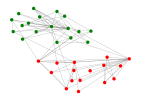

In [42]:
## re-run and plot top result
dim, algo, param, _ = first(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/Zachary/zachary.edgelist -o:_embed -d:$dim -p:$p -q:$q`
    run(x, wait=true)
elseif algo=="hope"
    X = Hope(z,param,dim)
    saveEmbedding(X,z) 
else
    X = LE(z,dim)
    saveEmbedding(X,z)
end

l = embed2layout()
gplot(z_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

In [43]:
last(L, 10)

10×4 DataFrame
 Row │ dim    alg     param     jsd        
     │ Int64  String  Any       Float64    
─────┼─────────────────────────────────────
   1 │     5  n2v     (1, 1)    0.00742752
   2 │    10  hope    aa        0.00773842
   3 │    10  le                0.00952332
   4 │    15  n2v     (1, 1)    0.010005
   5 │     5  n2v     (1, 0.1)  0.0111216
   6 │    10  n2v     (1, 0.1)  0.0125641
   7 │    10  n2v     (0.1, 1)  0.0128401
   8 │    15  n2v     (0.1, 1)  0.0133456
   9 │    10  n2v     (1, 1)    0.0146752
  10 │     5  n2v     (0.1, 1)  0.0166963


An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//Zachary/zachary.edgelist
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=5
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO


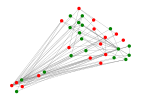

In [44]:
## re-run and plot bottom result
dim, algo, param, _ = last(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/Zachary/zachary.edgelist -o:_embed -d:$dim -p:$p -q:$q`
    run(x, wait=true)
elseif algo=="hope"
    X = Hope(z,param,dim)
    saveEmbedding(X,z) 
else
    X = LE(z,dim)
    saveEmbedding(X,z)
end

l = embed2layout()
gplot(z_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Perform several embeddings -- small ABCD  graph
* node2vec from source code
* HOPE different similarities
* Laplacian Eigenmaps
* visualize some good and bad results

In [45]:
L = DataFrame()
DIM = [2,4,8,16,24,32]

6-element Vector{Int64}:
  2
  4
  8
 16
 24
 32

In [46]:
## Hope
for dim in DIM, sim in (:katz,:ppr, :cn, :aa)
    X = Hope(g,sim,dim)
    saveEmbedding(X,g)
    jsd = JS(datadir * "ABCD/abcd_100.dat", datadir * "ABCD/abcd_100.ecg", "_embed")
    push!(L, (dim=dim, alg="hope", param=sim, jsd=jsd))
end

In [47]:
## LE
for dim in DIM
    X = LE(g,dim)
    saveEmbedding(X,g)
    jsd = JS(datadir * "ABCD/abcd_100.dat", datadir * "ABCD/abcd_100.ecg", "_embed")
    push!(L, (dim=dim, alg="le", param=nothing,jsd=jsd), cols=:union)
end

In [48]:
## node2vec is in my path
for dim in DIM, (p,q) in [(1,0.1),(0.1,1),(1,1)]
        x = `../node2vec/node2vec -i:$datadir/ABCD/abcd_100.dat -o:_embed -d:$dim -p:$p -q:$q`
        @show x
        run(x, wait=true)
        jsd = JS(datadir * "ABCD/abcd_100.dat" ,datadir * "ABCD/abcd_100.ecg", "_embed")
        @show (dim,p,q,jsd)
        push!(L, (dim=dim, alg="n2v", param=(p,q),jsd=jsd), cols=:union)
end

x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:2 -p:1 -q:0.1`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abcd_100.dat
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=2
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=1
Inout hyperparameter. Default is 1 (-q:)=0.1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO
(dim, p, q, jsd) = (2, 1, 0.1, 0.001674505)
x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:2 -p:0.1 -q:1`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abcd_100.dat
Output graph 

(dim, p, q, jsd) = (16, 1, 0.1, 0.0002582191)
x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:16 -p:0.1 -q:1`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-i:)=../Datasets//ABCD/abcd_100.dat
Output graph path (-o:)=_embed
Number of dimensions. Default is 128 (-d:)=16
Length of walk per source. Default is 80 (-l:)=80
Number of walks per source. Default is 10 (-r:)=10
Context size for optimization. Default is 10 (-k:)=10
Number of epochs in SGD. Default is 1 (-e:)=1
Return hyperparameter. Default is 1 (-p:)=0.1
Inout hyperparameter. Default is 1 (-q:)=1
Verbose output. (-v)=NO
Graph is directed. (-dr)=NO
Graph is weighted. (-w)=NO
Output random walks instead of embeddings. (-ow)=NO
(dim, p, q, jsd) = (16, 0.1, 1, 0.001495071)
x = `../node2vec/node2vec -i:../Datasets//ABCD/abcd_100.dat -o:_embed -d:16 -p:1 -q:1`

An algorithmic framework for representational learning on graphs. [Apr  5 2021]
Input graph path (-

In [49]:
sort!(L, :jsd)
first(L, 10)

10×4 DataFrame
 Row │ dim    alg     param  jsd         
     │ Int64  String  Any    Float64     
─────┼───────────────────────────────────
   1 │    16  hope    ppr    8.23976e-5
   2 │    16  hope    katz   8.99186e-5
   3 │    32  hope    ppr    9.62746e-5
   4 │    24  le             0.000128475
   5 │     8  le             0.000128605
   6 │    24  hope    ppr    0.00012949
   7 │    16  hope    cn     0.000140079
   8 │    24  hope    katz   0.000141626
   9 │    32  le             0.000156236
  10 │    32  hope    katz   0.00019062

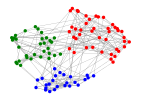

In [50]:
## re-run and plot top result
dim, algo, param, _ = first(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/ABCD/abcd_100.dat -o:_embed -d:$dim -p:$p -q:$q`
    run(x)
elseif algo=="hope"
    X = Hope(g,param,dim)
    saveEmbedding(X,g) 
else
    X = LE(g,dim)
    saveEmbedding(X,g)
end

l = embed2layout()
v_color = cls[g.vs.get_attribute_values("comm")]
gplot(g_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

In [51]:
last(L, 10)

10×4 DataFrame
 Row │ dim    alg     param     jsd        
     │ Int64  String  Any       Float64    
─────┼─────────────────────────────────────
   1 │     4  hope    katz      0.00140282
   2 │    24  hope    aa        0.00142616
   3 │    32  hope    aa        0.00145591
   4 │    16  n2v     (0.1, 1)  0.00149507
   5 │     2  n2v     (1, 0.1)  0.0016745
   6 │     2  hope    ppr       0.00244788
   7 │     4  n2v     (0.1, 1)  0.00255613
   8 │     2  hope    cn        0.00277605
   9 │     2  hope    katz      0.00277826
  10 │     2  hope    aa        0.00277826

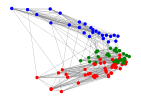

In [52]:
## re-run and plot bottom result
dim, algo, param, _ = last(L)
if algo=="n2v"
    p, q = param
    x = `../node2vec/node2vec -i:$datadir/ABCD/abcd_100.dat -o:_embed -d:$dim -p:$p -q:$q`
    run(x)
elseif algo=="hope"
    X = Hope(g,param,dim)
    saveEmbedding(X,g) 
else
    X = LE(g,dim)
    saveEmbedding(X,g)
end

l = embed2layout()
gplot(g_lg, l[:, 1], l[:, 2],
      NODESIZE=0.03, nodefillc=v_color,
      EDGELINEWIDTH=0.2, edgestrokec="gray")

# Large ABCD graph -- find a good embedding with the framework
* we only look as 16 configurations with HOPE for now (for speed)
* we'll consider more in the large classification experiment later

The good embedding was generated using the code provided in the Python notebook

# Classification on larger ABCD graph

* we use a good embedding saved from above cell
* we use a random forest model on embedded space
* we split the data as train and test
* the goal is to recover the communities for each node


In [53]:
## used saved "best" embedding from above
X = readEmbedding(datadir * "ABCD/abcd_1000_embed_best")

1000×48 Matrix{Float64}:
 -0.0494927    0.0182578     0.00612948   …   0.0235213   -0.0404697
  0.00194183   0.0556905    -0.00576875      -0.00938255  -0.0289375
 -0.0222129    0.0254334     0.0203826        0.0242293   -0.103679
  0.0229073    0.0027756    -0.00633039      -0.0106431   -0.0289911
  0.0231432   -0.00397185    0.0198622       -0.00422675  -0.0270434
 -0.00698369   0.0374435    -0.0155515    …  -0.0163239   -0.0731299
 -0.0273287   -0.0252472    -0.000137054      0.0306771   -0.030823
 -0.0204198   -0.0354117    -0.0161421        0.0529033   -0.0545485
  0.0416094   -0.0092815    -0.0502833        0.00441679  -0.0244935
  0.0434086   -0.021118     -0.00295279      -0.0266812   -0.0273966
 -0.00835757  -0.0323856     0.00470476   …   0.00860569  -0.0253205
  0.0142279   -0.0293603    -0.0329347        0.0401811   -0.0338684
 -0.00107683  -0.0406091    -0.0462375        0.038364    -0.0236052
  ⋮                                       ⋱               
 -0.00840536   0.0403

In [54]:
y = string.(G.vs.get_attribute_values("comm"))

1000-element Vector{String}:
 "4"
 "11"
 "4"
 "10"
 "4"
 "10"
 "12"
 "12"
 "1"
 "5"
 "3"
 "6"
 "8"
 ⋮
 "6"
 "11"
 "9"
 "1"
 "6"
 "3"
 "11"
 "5"
 "5"
 "1"
 "8"
 "5"

In [55]:
## train/test split
Random.seed!(1234)
to_train = falses(length(y))
to_train[1:round(Int, length(y)*0.25)] .= true
shuffle!(to_train)

1000-element BitVector:
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 1

In [56]:
X_train = X[to_train, :]
X_test = X[.!to_train, :]
y_train = y[to_train]
y_test = y[.!to_train]

750-element Vector{String}:
 "4"
 "11"
 "4"
 "4"
 "10"
 "12"
 "12"
 "1"
 "5"
 "3"
 "6"
 "8"
 "2"
 ⋮
 "7"
 "8"
 "6"
 "11"
 "9"
 "1"
 "3"
 "11"
 "5"
 "5"
 "1"
 "8"

In [57]:
model = build_forest(y_train, X_train, size(X, 2) ÷ 2, 100, 0.5)

Ensemble of Decision Trees
Trees:      100
Avg Leaves: 25.94
Avg Depth:  6.61

In [58]:
y_pred = apply_forest(model, X_test)

750-element Vector{String}:
 "4"
 "11"
 "4"
 "4"
 "10"
 "12"
 "12"
 "1"
 "5"
 "3"
 "6"
 "7"
 "2"
 ⋮
 "7"
 "8"
 "6"
 "4"
 "9"
 "1"
 "3"
 "4"
 "5"
 "5"
 "1"
 "8"

In [59]:
cm = freqtable(y_test, y_pred)

12×12 Named Matrix{Int64}
Dim1 ╲ Dim2 │  1  10  11  12   2   3   4   5   6   7   8   9
────────────┼───────────────────────────────────────────────
1           │ 76   0   0   0   2   2   0   0   1   1   0   0
10          │  2  44   0   0   0   0   0   2   0   0   0   0
11          │  0   0  35   0   0   0   6   0   0   0   0   0
12          │  1   0   0  42   0   0   0   0   0   0   0   0
2           │  3   0   0   0  75   0   0   0   0   1   1   0
3           │  0   0   1   0   1  67   0   1   2   0   0   1
4           │  3   0   0   0   0   3  69   0   0   0   0   1
5           │  2   0   1   0   0   3   1  69   0   0   1   0
6           │  1   0   0   0   0   0   0   0  57   0   1   0
7           │  1   0   0   0   0   0   1   1   0  57   0   0
8           │  2   0   0   1   0   0   3   0   0   2  49   0
9           │  1   0   0   1   1   0   1   1   0   0   1  48

In [60]:
@info "accuracy: $(sum(diag(cm))/length(y_test))"

┌ Info: accuracy: 0.9173333333333333
└ @ Main In[60]:1


In [61]:
## compare with random classifier -- assuming we know only the number of classes (12)
describe([sum(diag(freqtable(rand(1:12, length(y_test)), y_test)))/length(y_test) for i in 1:10000])

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.083351
Minimum:        0.044000
1st Quartile:   0.076000
Median:         0.082667
3rd Quartile:   0.090667
Maximum:        0.124000
Type:           Float64


In [62]:
## compare with random classifier -- using class proportions in training data
describe([sum(diag(freqtable(rand(y_train, length(y_test)), y_test)))/length(y_test) for i in 1:10000])

Summary Stats:
Length:         10000
Missing Count:  0
Mean:           0.088783
Minimum:        0.052000
1st Quartile:   0.081333
Median:         0.088000
3rd Quartile:   0.096000
Maximum:        0.132000
Type:           Float64


# Clustering
* we run graph clustering (Louvain, ECG)
* we compare with vector space embedding using same embedding
* we use k-means (various k) and DBSCAN
* recall there are 12 ground truth community

In [63]:
## again we use 'good' embedding from before
X = readEmbedding(datadir * "ABCD/abcd_1000_embed_best")

1000×48 Matrix{Float64}:
 -0.0494927    0.0182578     0.00612948   …   0.0235213   -0.0404697
  0.00194183   0.0556905    -0.00576875      -0.00938255  -0.0289375
 -0.0222129    0.0254334     0.0203826        0.0242293   -0.103679
  0.0229073    0.0027756    -0.00633039      -0.0106431   -0.0289911
  0.0231432   -0.00397185    0.0198622       -0.00422675  -0.0270434
 -0.00698369   0.0374435    -0.0155515    …  -0.0163239   -0.0731299
 -0.0273287   -0.0252472    -0.000137054      0.0306771   -0.030823
 -0.0204198   -0.0354117    -0.0161421        0.0529033   -0.0545485
  0.0416094   -0.0092815    -0.0502833        0.00441679  -0.0244935
  0.0434086   -0.021118     -0.00295279      -0.0266812   -0.0273966
 -0.00835757  -0.0323856     0.00470476   …   0.00860569  -0.0253205
  0.0142279   -0.0293603    -0.0329347        0.0401811   -0.0338684
 -0.00107683  -0.0406091    -0.0462375        0.038364    -0.0236052
  ⋮                                       ⋱               
 -0.00840536   0.0403

In [64]:
L = DataFrame()
K = [6,9,12,15,24] ## for k-means (real number of clusters is 12)
REP = 30

for i in 1:REP
    ## kmeans
    for k in K
        labels = kmeans(X', k).assignments
        scr = CHS(X, labels)
        ami = AMI(G.vs.get_attribute_values("comm"), labels)
        push!(L, (method="km", param=k, scr=scr, ami=ami))
    end
    ## ECG
    ec = G.community_ecg().membership
    scr = G.modularity(ec)
    ami = AMI(G.vs.get_attribute_values("comm"),ec)
    push!(L, (method="ecg", param=nothing, scr=scr, ami=ami), cols=:union)
    ## Louvain -- permute as this is not done in igraph
    p = randperm(G.vcount()) .- 1
    GG = G.permute_vertices(Any[x for x in p])
    l = GG.community_multilevel().membership
    ll = similar(l)
    for i in 1:length(l)
        ll[i] = l[p[i] + 1]
    end
    scr = G.modularity(ll)
    ami = AMI(G.vs.get_attribute_values("comm"),ll)
    push!(L, (method="ml", param=nothing, scr=scr, ami=ami), cols=:union)
end

In [65]:
combine(groupby(L, :method), x -> last(sort(x, :scr)))

3×4 DataFrame
 Row │ method  param   scr        ami      
     │ String  Union…  Float64    Float64  
─────┼─────────────────────────────────────
   1 │ km      12      17.3325    0.943812
   2 │ ecg              0.355177  0.995294
   3 │ ml               0.354881  0.987246

In [66]:
gL = groupby(L, [:method, :param], sort=true)

GroupedDataFrame with 7 groups based on keys: method, param
First Group (30 rows): method = "ecg", param = nothing
 Row │ method  param   scr       ami      
     │ String  Union…  Float64   Float64  
─────┼────────────────────────────────────
   1 │ ecg             0.354593  0.985448
   2 │ ecg             0.354738  0.984214
   3 │ ecg             0.354881  0.987246
   4 │ ecg             0.354919  0.98411
   5 │ ecg             0.355177  0.995294
   6 │ ecg             0.354549  0.97866
   7 │ ecg             0.355079  0.992944
   8 │ ecg             0.355079  0.992944
   9 │ ecg             0.354872  0.985914
  10 │ ecg             0.355177  0.995294
  11 │ ecg             0.354441  0.981078
  ⋮  │   ⋮       ⋮        ⋮         ⋮
  20 │ ecg             0.354941  0.988933
  21 │ ecg             0.354903  0.992943
  22 │ ecg             0.354881  0.983462
  23 │ ecg             0.354883  0.988213
  24 │ ecg             0.354553  0.977333
  25 │ ecg             0.354158  0.974379
  26 │ ecg             0.355083  0.988182
  27 │ ecg             0.354869  0.984868
  28 │ ecg             0.354909  0.984133
  29 │ ecg             0.354883  0.988213
  30 │ ecg             0.354976  0.986382
                            8 rows omitted
⋮
Last Group (30 rows): method = "ml", param = nothing
 Row │ method  param   scr       ami      
     │ String  Union…  Float64   Float64  
─────┼────────────────────────────────────
   1 │ ml              0.348192  0.921182
   2 │ ml              0.338819  0.870589
   3 │ ml              0.340823  0.876686
   4 │ ml              0.354467  0.975932
   5 │ ml              0.342196  0.900489
   6 │ ml              0.342965  0.892392
   7 │ ml              0.354224  0.974589
   8 │ ml              0.349356  0.939916
   9 │ ml              0.324097  0.751092
  10 │ ml              0.327104  0.780991
  11 │ ml              0.338374  0.821496
  ⋮  │   ⋮       ⋮        ⋮         ⋮
  20 │ ml              0.349575  0.941412
  21 │ ml              0.330056  0.799615
  22 │ ml              0.338761  0.872849
  23 │ ml              0.333914  0.792586
  24 │ ml              0.348862  0.936319
  25 │ ml              0.348102  0.918683
  26 │ ml              0.345493  0.900544
  27 │ ml              0.328307  0.745109
  28 │ ml              0.343347  0.88915
  29 │ ml              0.342892  0.926816
  30 │ ml              0.329656  0.802507
                            8 rows omitted

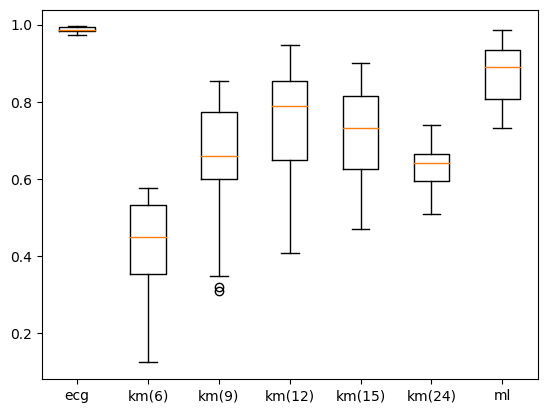

(PyObject[PyObject <matplotlib.axis.XTick object at 0x7fb9f00efb90>, PyObject <matplotlib.axis.XTick object at 0x7fb9f00ef1d0>, PyObject <matplotlib.axis.XTick object at 0x7fb9e3ed4410>, PyObject <matplotlib.axis.XTick object at 0x7fb9e3ed4d10>, PyObject <matplotlib.axis.XTick object at 0x7fb9e3c6d8d0>, PyObject <matplotlib.axis.XTick object at 0x7fb9e3c6ddd0>, PyObject <matplotlib.axis.XTick object at 0x7fb9e3d2b3d0>], PyObject[PyObject Text(1, 0, 'ecg'), PyObject Text(2, 0, 'km(6)'), PyObject Text(3, 0, 'km(9)'), PyObject Text(4, 0, 'km(12)'), PyObject Text(5, 0, 'km(15)'), PyObject Text(6, 0, 'km(24)'), PyObject Text(7, 0, 'ml')])

In [67]:
boxplot([sdf.ami for sdf in gL])
xticks(1:7, [isnothing(p) ? m : "$m($p)" for (m,p) in keys(gL)])

In [68]:
## DBSCAN -- we tried different epsilon and dim
## test via calinski_harabasz_score (CHS) or silhouette_score or davies_bouldin_score
## best result obtained empirically with min_samples = 8

top = 0
for dim in [4,8,16,24,32,40,48,64], ms in [8]
    U = umap.UMAP(n_components=24).fit_transform(X)
    for e in 0.4:0.0025:0.5
        cl = DBSCAN(U, eps=e, min_samples=ms)
        labels = cl[2]
        s = CHS(U,labels) ## score
        if s > top
            global top = s
            global e_top = e
            global d_top = dim
            global m_top = ms
        end
    end
end

U = umap.UMAP(n_components=d_top).fit_transform(X)
cl = DBSCAN(U, eps=e_top, min_samples=m_top)
labels = cl[2]

b = labels .> -1
println("AMI without outliers: ", AMI(G.vs.get_attribute_values("comm")[b], labels[b]))
println("AMI with outliers: ", AMI(G.vs.get_attribute_values("comm"), labels))

AMI without outliers: 0.8816429359191802
AMI with outliers: 0.6678225864888017


# Link prediction

* we drop 10% edges and re-compute the embedding (same parameters as best one)
* we train a logistic regression model
* we use validation set to pick best operator
* we apply final model to test set

Link/edge embeddings for the positive and negative edge samples is obtained
by applying a binary operator on the embeddings of the source and target nodes 
of each sampled edge. We consider 4 different operators and select via validation.


In [105]:
## pick 10% edges at random, save new graph as Gp
Random.seed!(12345)
test_size = round(Int, 0.1*G.ecount())
test_eid = sample(0:G.ecount()-1, test_size, replace=false)
Gp = G.copy()
Gp.delete_edges(test_eid)

## compute embedding on Gp 
X = Hope(Gp, :ppr, 64)

1000×64 Matrix{Float64}:
 0.0400349  -0.0435743    0.0391045   …   0.0216307     0.00703781
 0.0310164   0.0141493   -0.0033964      -0.00601685   -0.0206618
 0.108597   -0.042016     0.0857755      -0.0133625     0.00347484
 0.0298402   0.012294     0.00684874      0.000794759   0.00101338
 0.0275603  -0.00929901   0.0356051       0.0072611    -0.0479009
 0.0729972  -0.0060304   -0.0179828   …   0.0371585    -0.0401923
 0.0302159  -0.0306055   -0.0215756       0.0250239     0.00452423
 0.0535558  -0.0445711   -0.0753357       0.0227926     0.00345948
 0.0208492   0.00620881   0.00925768      0.0249295    -0.0131657
 0.0254641   0.00487203  -0.0036044      -0.028064      0.00244706
 0.0245242  -0.0146183   -0.0203082   …  -0.00311516   -0.0191418
 0.0367819  -0.0463019    0.00478666     -0.0164126    -0.0433616
 0.0222794  -0.0459379   -0.0186945       0.0162297     0.00534878
 ⋮                                    ⋱                
 0.0221115  -0.0106281   -0.0203851      -0.0255265   

In [106]:
## validation round in Gp to select operator
for op in [:had,:l1,:l2,:avg]
    ## all edges (positive cases)
    F = [binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op) for e in Gp.es]
    sz = length(F)
    f = [fill(1, length(F)); fill(0, length(F))]

    ## features for node pairs without edges
    ctr = 0
    while ctr < sz
        a = rand(0:Gp.vcount()-1)
        b = rand(0:Gp.vcount()-1)
        a == b && continue
        if Gp.get_eid(a, b, directed=false, error=false) == -1
            push!(F, binary_operator(X[a+1, :],X[b+1, :], op))
            ctr += 1
        end
    end
    F = permutedims(reduce(hcat, F))
    Random.seed!(1234)
    to_train = falses(length(f))
    to_train[1:round(Int, length(f)*0.1)] .= true
    shuffle!(to_train)
    X_train = F[to_train, :]
    X_test = F[.!to_train, :]
    y_train = f[to_train]
    y_test = f[.!to_train]
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    println("Accuracy of logistic regression classifier with $op on validation set: ", logreg.score(X_test, y_test))
end

Accuracy of logistic regression classifier with had on validation set: 0.4997405293201868
Accuracy of logistic regression classifier with l1 on validation set: 0.7687745570464823
Accuracy of logistic regression classifier with l2 on validation set: 0.4997405293201868
Accuracy of logistic regression classifier with avg on validation set: 0.586477870857736


In [107]:
## Train model with best operator ('l1' here, but this may vary)
op = :l1

F = [binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op) for e in Gp.es]
sz = length(F)
f = [fill(1, length(F)); fill(0, length(F))]

## features for node pairs without edges
ctr = 0
while ctr < sz
    a = rand(0:Gp.vcount()-1)
    b = rand(0:Gp.vcount()-1)
    a == b && continue
    if Gp.get_eid(a, b, directed=false, error=false) == -1
        push!(F, binary_operator(X[a+1, :],X[b+1, :], op))
        ctr += 1
    end
end
F = permutedims(reduce(hcat, F))

logreg = LogisticRegression()
logreg.fit(F,f)

op = :l1
X_test = [(e = G.es[i]; binary_operator(X[e.tuple[1]+1, :],X[e.tuple[2]+1, :],op)) for i in test_eid]
sz = length(X_test)
y_test = [fill(1, length(X_test)); fill(0, length(X_test))]

ctr = 0
while ctr < sz
    a = rand(0:G.vcount()-1)
    b = rand(0:G.vcount()-1)
    a == b && continue
    if Gp.get_eid(a, b, directed=false, error=false) == -1
        push!(X_test, binary_operator(X[a+1, :],X[b+1, :], op))
        ctr += 1
    end
end
X_test = permutedims(reduce(hcat, X_test))

y_pred = logreg.predict(X_test)
println("Accuracy of logistic regression classifier with $op on validation set: ", logreg.score(X_test, y_test))
freqtable(y_test, y_pred)

Accuracy of logistic regression classifier with l1 on validation set: 0.7995198079231692


2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │   0    1
────────────┼─────────
0           │ 690  143
1           │ 191  642

In [ ]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='gray',label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('')
plt.legend(loc="lower right")
#plt.savefig('embed_link.eps')
plt.show();

## Larger study -- use accuracy for picking embedding

- we training-validation-test split
- this can be long to run -- a pickle file with the results is included in data directory
- to re-run from scratch, uncomment the next cell

In [ ]:
## load L and train/val/test ids
id_train,id_val,id_trainval,id_test,L = pickle.load(open(datadir+"ABCD/abcd_1000_embeddings.pkl","rb"))
y_all = G.vs['comm']
y_train = [y_all[i] for i in id_train]
y_trainval = [y_all[i] for i in id_trainval]
y_val = [y_all[i] for i in id_val]
y_test = [y_all[i] for i in id_test]

In [ ]:
R = pd.DataFrame(L,columns=['dim','algo','param','div','acc'])
from scipy.stats import kendalltau as tau
print(tau(R['div'],R['acc']))


In [ ]:
## sort by Divergence on validation set
R = R.sort_values(by='div',axis=0,ascending=True)
size = R.shape[0]
R['rank_div'] = np.arange(1,size+1,1)
R.head()


In [ ]:
## sort by Accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
size = R.shape[0]
R['rank_acc'] = np.arange(1,size+1,1)
R.head()


In [ ]:
## quite a range of accuracy on the validation set!
R.tail()

In [ ]:
## retrain and score in order of validation set's accuracy
## and apply to test set. This takes a few minutes to run.

top_acc = []
for i in range(size):
    dim, algo, param, div, acc, rk_a, rk_d = R.iloc[i]
    if algo=='n2v':
        s = param.split()
        p = float(s[0])
        q = float(s[1])
        x = 'node2vec -i:'+datadir+'ABCD/abcd_1000.dat -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        X = readEmbedding(N2K=N2K)
    if algo=='hope':
        X = Hope(G,sim=param,dim=dim)
    if algo=='le':
        X = LE(G, dim=dim)
        
    X_trainval = X[id_trainval,:]
    X_test = X[id_test,:]
    # Create the model with 100 trees
    model = RandomForestClassifier(n_estimators=100, 
                                   bootstrap = True,
                                   max_features = 'sqrt')
    # Fit on training data
    model.fit(X_trainval, y_trainval)

    # Actual class predictions
    y_pred = model.predict(X_test)
    scr = accuracy_score(y_test,y_pred)
    top_acc.append(scr)

R['test'] = top_acc
print('mean accuracy over all models on test set:',np.mean(R['test']))

In [ ]:
R = R.sort_values(by='test',axis=0,ascending=False)
R['rank_test'] = np.arange(1,size+1,1)
R.head()

In [ ]:
## top results on test set w.r.t. divergence on validation set
R = R.sort_values(by='div',axis=0,ascending=True)
top_div = R['test'][:10]

## top results on test set w.r.t. accuracy on validation set
R = R.sort_values(by='acc',axis=0,ascending=False)
top_acc = R['test'][:10]


In [ ]:
## pd with mu
B = pd.DataFrame(np.transpose(np.array([top_acc,top_div])), 
                 columns=['Top-10 validation set accuracy','Top-10 divergence score'])
B.boxplot(rot=0,figsize=(7,5))
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('embed_classify.eps')

In [ ]:
plt.plot(R['rank_acc'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_accuracy.eps');

In [ ]:
plt.plot(R['rank_div'],R['test'],'.',color='black')
plt.xlabel('Rank',fontsize=14)
plt.ylabel('Test set accuracy',fontsize=14);
#plt.savefig('rank_divergence.eps');

In [ ]:
## random classification -- AMI
ctr = Counter(y_trainval)
x = [ctr[i+1] for i in range(12)]
s = np.sum(x)
p = [i/s for i in x]
y_pred = [x+1 for x in np.random.choice(12,size=len(y_test),replace=True,p=p)]
cm = confusion_matrix(y_test, y_pred)
print('\nRandom classifier accuracy on test set:',sum(cm.diagonal())/sum(sum(cm)))


## ReFex: illustrate roles on Zachary graph

We use the 'graphrole' package


In [ ]:
# extract features
feature_extractor = RecursiveFeatureExtractor(z, max_generations=5)
features = feature_extractor.extract_features()
print(f'\nFeatures extracted from {feature_extractor.generation_count} recursive generations:')
features.head(10)

In [ ]:
# assign node roles in a dictionary
role_extractor = RoleExtractor(n_roles=3)
role_extractor.extract_role_factors(features)
node_roles = role_extractor.roles
role_extractor.role_percentage.head()

In [ ]:
#import seaborn as sns
# build color palette for plotting
unique_roles = sorted(set(node_roles.values()))
#color_map = sns.color_palette('Paired', n_colors=len(unique_roles))

cls = ['red','blue','green']
# map roles to colors
role_colors = {role: cls[i] for i, role in enumerate(unique_roles)}

# store colors for all nodes in G
z.vs()['color'] = [role_colors[node_roles[node]] for node in range(z.vcount())]

## Plot with node labels
z.vs()['size'] = 10
#z.vs()['label'] = [v.index for v in z.vs()]
z.vs()['label_size'] = 0
#ig.plot(z, 'refex.eps', bbox=(0,0,300,300)) 
ig.plot(z, bbox=(0,0,300,300)) 



# Anomaly detection

## Dataset -- American College Football Graph

[REF]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799


Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as anomalies as can be seen in Figure 5 of [REF], namely:
- 5 teams in #5 conference (Independent) play teams in other conferences (green triangles)
- 7 teams in #10 conference (Sun Belt) are broken in 2 clumps (pink triangles) 
- 2 teams from #11 conference play mainly with #10 conference (red triangles)

Here, we try to recover those anomalous teams by running several embeddings (we use node2vec):

- for each embedding:
 - compute divergence using our framework
 - also compute entropy of b-vector for each node (probability distribution of edges w.r.t. every community in the geometric Chung-Lu model)
- plot entropy vs divergence
- for some good/bad embedding, boxplot entropy of anomalous vs other nodes



In [ ]:
## read graph and communities
g = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
g.vs['community'] = [c[int(x['name'])] for x in g.vs]

## Read and plot the College Football Graph
g.vs['shape'] = 'circle'
g.vs['anomaly'] = 0
pal = ig.RainbowPalette(n=max(g.vs['community'])+1) 
g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
for v in g.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='triangle'
        v['anomaly']=1
ly = g.layout_fruchterman_reingold()
ig.plot(g, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


In [ ]:
## greyscale
pal = ig.GradientPalette("white","black",max(g.vs['community'])+1)
g.vs['color'] = [pal.get(int(i)) for i in g.vs['community']]
ig.plot(g, layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')
#ig.plot(g, target="anomaly_1.eps", layout=ly, bbox=(0,0,500,300), vertex_size=8, edge_color='lightgray')


In [ ]:
## node2vec with varying parameters (36 embeddings)
L = []
for dim in np.arange(2,25,2):
    for (p,q) in [(1,0),(0,1),(1,1)]:
        x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
        r = os.system(x)
        jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
        ent = list(pd.read_csv('_entropy',header=None)[1])
        g.vs['ent'] = ent
        roc = roc_auc_score(g.vs['anomaly'], ent)
        L.append([dim,'n2v',str(p)+' '+str(q),jsd,roc])
D = pd.DataFrame(L,columns=['dim','algo','param','jsd','auc'])
D = D.sort_values(by='jsd',axis=0)
D.head()

In [ ]:
D.tail()

In [ ]:
## auc vs divergence (jsd)
plt.plot(D['jsd'],D['auc'],'o',color='black')
plt.xlabel('JS Divergence',fontsize=14)
plt.ylabel('AUC',fontsize=14);
#plt.savefig('anomaly_2.eps')

In [ ]:
## Entropy scores - some good embedding
p=q=1
dim=16
x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
r = os.system(x)
jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
g.vs['ent'] = list(pd.read_csv('_entropy',header=None)[1])
X = [v['ent'] for v in g.vs if v['anomaly']==0]
Y = [v['ent'] for v in g.vs if v['anomaly']==1]
plt.boxplot([X,Y],labels=['Regular','Anomalous'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('Entropy',fontsize=14);
#plt.savefig('anomaly_3.eps')

## AUC using average rank with several top embeddings

In [ ]:
from scipy.stats import rankdata
## try with top-k embeddings together - hopefully this consistently yields high AUC
k = 7
g.vs['rank'] = 0
for i in range(k):
    dim = D.iloc[i]['dim']
    p = int(D.iloc[0]['param'].split()[0])
    q = int(D.iloc[0]['param'].split()[1])
    x = 'node2vec -i:'+datadir+'Football/football.edgelist -o:_embed -d:'+str(dim)+' -p:'+str(p)+' -q:'+str(q)
    r = os.system(x)
    jsd = JS(datadir+'Football/football.edgelist',datadir+'Football/football.ecg','_embed',entropy=True)
    g.vs['ent'] = list(pd.read_csv('_entropy',header=None)[1])
    rk = rankdata(g.vs['ent'])
    for i in range(len(rk)):
        g.vs[i]['rank'] += rk[i]
print('AUC:',roc_auc_score(g.vs['anomaly'], g.vs['rank']))